#### Necessary Library

In [54]:
!pip install pygsheets
!pip install --upgrade -q pygsheets
!pip install clean-text[gpl]

In [55]:
!pip install geopandas

In [0]:
# import the necessary library
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np 
import os
import ast

from datetime import datetime
import re
import string
from pprint import pprint
from cleantext import clean

import seaborn as sns
import matplotlib.pyplot as plt

import pygsheets

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 400 # this will set limit of columns to 500
pd.options.display.max_rows = 400 # this will set limit of columns to 500

# pd.options.display.max_colwidth
#pd.options.display.max_colwidth = 100
pd.options.display.max_colwidth = 200

#### Authentification Google

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Authentification with google drive and colab
from google.colab import auth
auth.authenticate_user()

# Read google sheet
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

### Data Preparation

In [59]:
!pip install python-sld

In [0]:
root_path = 'drive/My Drive/Personal Projects/2020/Sport_CASA/sport/data/'  

In [61]:
project_id = 'nature-casa'
!gcloud config set project {project_id}

Updated property [core/project].


### Step0 - Read the Geo Boundaries (Canton Vaud, CH)

- Data source: https://www.asitvd.ch/index.php?option=com_easysdi_catalog&view=sheet&guid=196&catalog=main&type=complete&preview=search_list&tmpl=component



#### open shapefile in geopandas dataframe

In [0]:
path_lake = 'GeoBoundaries/Vaud/SHP/MN03/MN03_OIT_TPR_LAD_GEN_LAC.shp'
path_district = 'GeoBoundaries/Vaud/SHP/MN03/MN03_OIT_TPR_LAD_GEN_DISTRICT.shp'
path_commune = 'GeoBoundaries/Vaud/SHP/MN03/MN03_OIT_TPR_LAD_GEN_COMMUNE.shp'
path_vs = 'GeoBoundaries/Valais/valais_communes.shp'

In [0]:
gdf_lake = gpd.read_file(root_path+path_lake)
gdf_dis = gpd.read_file(root_path+path_district)
gdf_com = gpd.read_file(root_path+path_commune)
gdf_vs = gpd.read_file(root_path+path_vs)

In [75]:
gdf_com.head(1)

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((550937.810 161156.590, 550587.860 161062.550, 550361.720 161126.930, 550076.960 161285.320, 550142.830 161402.590, 550158.320 161766.110, 550030.720 161735.340, 549671.140 161851.700, 54..."


In [65]:
gdf_dis.NOM_MIN.unique()

array(['Nyon', 'Jura-Nord vaudois', 'Lavaux-Oron', 'Aigle', 'Lausanne',
       'Broye-Vully', "Riviera-Pays d'Enhaut", 'Ouest lausannois',
       'Morges', 'Gros-de-Vaud'], dtype=object)

##### Visualize the Shapefile

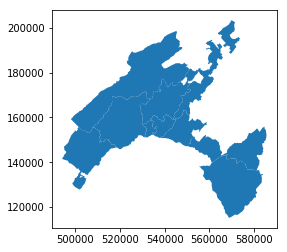

In [0]:
gdf_dis.plot()

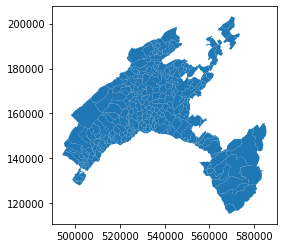

In [0]:
gdf_com.plot()

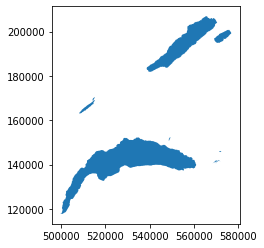

In [0]:
gdf_lake.plot()

##### Set the CRS - WGS84 (EPSG:4326)

In [0]:
gdf_vs

In [0]:
gdf_dis = gdf_dis.to_crs(epsg=4326)
gdf_com = gdf_com.to_crs(epsg=4326)
gdf_lake = gdf_lake.to_crs(epsg=4326)
gdf_vs.crs = 'EPSG:4326'

In [67]:
gdf_com.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Select Communes
- select the commune of Lausanne2020 venues
- read the venues geojson
- find in which commune the venues belong (merge pd)

In [0]:
path_venues = 'lausanne2020_venues.geojson'
gdf_venues = gpd.read_file(root_path+path_venues)

In [69]:
print('Number of Venues: '+str(len(gdf_venues)))
gdf_venues.head(3)

Number of Venues: 8


,venues,geometry
0,Lausanne,POINT (6.63227 46.51965)
1,Les Diablerets,POINT (7.15806 46.35139)
2,Leysin,POINT (7.01203 46.34356)


In [70]:
gdf_venues.venues.unique()

array(['Lausanne', 'Les Diablerets', 'Leysin', 'Villars',
       'Vallée de Joux ', 'Les Tuffes', 'Champéry', 'St. Moritz'],
      dtype=object)

###### Select only the district that have a venue (Point in Polygon) - JupyterNotebook

In [0]:
gdf_sjoin = gpd.sjoin(gdf_com, gdf_venues, how='inner', op='contains')
print('Number of Venues Matching: '+str(len(gdf_sjoin)))
gdf_sjoin.head(1)

Number of Venues Matching: 5


,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,index_right,venues
98,152,5.957599e+07,44563.707428,22,Ollon,OLLON,2221,5409,9,1,"POLYGON ((7.14664 46.30466, 7.14314 46.30574, 7.13940 46.30764, 7.13795 46.30744, 7.13323 46.30795, 7.13241 46.30829, 7.13044 46.30835, 7.12978 46.30872, 7.12854 46.30861, 7.12752 46.30915, 7.1248...",3,Villars


In [0]:
gdf_sjoin_sel = gdf_sjoin.loc[:,['NOM_MIN','venues']]
gdf_sjoin_sel

,NOM_MIN,venues
98,Ollon,Villars
131,Le Chenit,Vallée de Joux
152,Ormont-Dessus,Les Diablerets
299,Leysin,Leysin
300,Lausanne,Lausanne


##### District to select

In [0]:
list_dis = ['Ollon','Le Chenit','Ormont-Dessus','Leysin','Lausanne','La Rippe']

In [0]:
gdf_com_sel = gdf_com[gdf_com['NOM_MIN'].isin(list_dis)]

###### Select Valais Commune - Champéry

In [0]:
gdf_vs = gdf_vs[gdf_vs['NOM']=='Champéry']

In [89]:
gdf_vs

,OBJECTID,geodb_oid,GID,SURFACE,NOM,NO_OFS,NO_CANT,Shape__Are,Shape__Len,GlobalID,geometry
16,283,1423,10,38845509,Champéry,6151,159,8.092734e+07,44423.62624,67f17bf0-6ee4-46db-8399-597f9b092267,"POLYGON ((6.84202 46.13198, 6.84179 46.13202, 6.84133 46.13220, 6.84104 46.13224, 6.84046 46.13240, 6.84005 46.13256, 6.83987 46.13259, 6.83941 46.13262, 6.83919 46.13269, 6.83874 46.13278, 6.8386..."


##### Merge VS & Vaud Communes

In [0]:
gdf_vs = gdf_vs.loc[:,['NOM','geometry']]
gdf_vs = gdf_vs.rename(columns={'NOM':'name'})
gdf_com_sel = gdf_com_sel.loc[:,['NOM_MIN','geometry']]
gdf_com_sel = gdf_com_sel.rename(columns={'NOM_MIN':'name'})

In [98]:
gdf_append = gdf_com_sel.append(gdf_vs)
gdf_append = gdf_append.reset_index(drop=True)
gdf_append

,name,geometry
0,Ollon,"POLYGON ((7.14664 46.30466, 7.14314 46.30574, 7.13940 46.30764, 7.13795 46.30744, 7.13323 46.30795, 7.13241 46.30829, 7.13044 46.30835, 7.12978 46.30872, 7.12854 46.30861, 7.12752 46.30915, 7.1248..."
1,Le Chenit,"POLYGON ((6.29301 46.58095, 6.28848 46.58118, 6.27529 46.57279, 6.26924 46.56051, 6.26454 46.55998, 6.26196 46.55854, 6.25783 46.55777, 6.25534 46.55655, 6.24990 46.55228, 6.24803 46.55011, 6.2438..."
2,Ormont-Dessus,"POLYGON ((7.14664 46.30466, 7.14726 46.30702, 7.14624 46.30843, 7.14775 46.30868, 7.14919 46.30850, 7.14798 46.31185, 7.14805 46.31379, 7.14527 46.31414, 7.14348 46.31490, 7.14451 46.31738, 7.1459..."
3,La Rippe,"POLYGON ((6.07459 46.43217, 6.07684 46.43104, 6.08339 46.42868, 6.08418 46.42797, 6.08555 46.42868, 6.08705 46.42877, 6.08804 46.42919, 6.09112 46.43144, 6.09732 46.42852, 6.09550 46.42628, 6.0972..."
4,Leysin,"POLYGON ((6.97822 46.32955, 6.97796 46.33065, 6.97979 46.33308, 6.98552 46.33916, 6.98762 46.34610, 6.98861 46.34625, 6.99105 46.34879, 6.99326 46.35041, 6.99559 46.35012, 6.99651 46.35063, 6.9973..."
5,Lausanne,"MULTIPOLYGON (((6.70641 46.58134, 6.72081 46.58040, 6.71873 46.57720, 6.71857 46.57517, 6.71785 46.57417, 6.71800 46.57256, 6.71298 46.56611, 6.71216 46.56566, 6.71112 46.56578, 6.71028 46.56533, ..."
6,Champéry,"POLYGON ((6.84202 46.13198, 6.84179 46.13202, 6.84133 46.13220, 6.84104 46.13224, 6.84046 46.13240, 6.84005 46.13256, 6.83987 46.13259, 6.83941 46.13262, 6.83919 46.13269, 6.83874 46.13278, 6.8386..."


#### Merge Districts & Communes - Final DF

In [112]:
gdf_dis.head(1)

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry
0,7,3.072759e+08,120139.29954,22,Nyon,NYON,2228,None,None,8,"POLYGON ((6.08394 46.43950, 6.08563 46.44083, 6.08641 46.44388, 6.08440 46.44744, 6.07861 46.45036, 6.07442 46.45350, 6.07692 46.45759, 6.07346 46.45987, 6.07392 46.46347, 6.07311 46.46415, 6.0728..."


In [0]:
gdf_dis = gdf_dis.loc[:,['NOM_MIN','geometry']]
gdf_dis = gdf_dis.rename(columns={'NOM_MIN':'name'})
gdf_dis.loc[gdf_dis['name'] == 'Lausanne', ['name']] = 'Lausanne_District'

In [115]:
gdf_final = gdf_append.append(gdf_dis)
gdf_final = gdf_final.reset_index(drop=True)
gdf_final

,name,geometry
0,Ollon,"POLYGON ((7.14664 46.30466, 7.14314 46.30574, 7.13940 46.30764, 7.13795 46.30744, 7.13323 46.30795, 7.13241 46.30829, 7.13044 46.30835, 7.12978 46.30872, 7.12854 46.30861, 7.12752 46.30915, 7.1248..."
1,Le Chenit,"POLYGON ((6.29301 46.58095, 6.28848 46.58118, 6.27529 46.57279, 6.26924 46.56051, 6.26454 46.55998, 6.26196 46.55854, 6.25783 46.55777, 6.25534 46.55655, 6.24990 46.55228, 6.24803 46.55011, 6.2438..."
2,Ormont-Dessus,"POLYGON ((7.14664 46.30466, 7.14726 46.30702, 7.14624 46.30843, 7.14775 46.30868, 7.14919 46.30850, 7.14798 46.31185, 7.14805 46.31379, 7.14527 46.31414, 7.14348 46.31490, 7.14451 46.31738, 7.1459..."
3,La Rippe,"POLYGON ((6.07459 46.43217, 6.07684 46.43104, 6.08339 46.42868, 6.08418 46.42797, 6.08555 46.42868, 6.08705 46.42877, 6.08804 46.42919, 6.09112 46.43144, 6.09732 46.42852, 6.09550 46.42628, 6.0972..."
4,Leysin,"POLYGON ((6.97822 46.32955, 6.97796 46.33065, 6.97979 46.33308, 6.98552 46.33916, 6.98762 46.34610, 6.98861 46.34625, 6.99105 46.34879, 6.99326 46.35041, 6.99559 46.35012, 6.99651 46.35063, 6.9973..."
5,Lausanne,"MULTIPOLYGON (((6.70641 46.58134, 6.72081 46.58040, 6.71873 46.57720, 6.71857 46.57517, 6.71785 46.57417, 6.71800 46.57256, 6.71298 46.56611, 6.71216 46.56566, 6.71112 46.56578, 6.71028 46.56533, ..."
6,Champéry,"POLYGON ((6.84202 46.13198, 6.84179 46.13202, 6.84133 46.13220, 6.84104 46.13224, 6.84046 46.13240, 6.84005 46.13256, 6.83987 46.13259, 6.83941 46.13262, 6.83919 46.13269, 6.83874 46.13278, 6.8386..."
7,Nyon,"POLYGON ((6.08394 46.43950, 6.08563 46.44083, 6.08641 46.44388, 6.08440 46.44744, 6.07861 46.45036, 6.07442 46.45350, 6.07692 46.45759, 6.07346 46.45987, 6.07392 46.46347, 6.07311 46.46415, 6.0728..."
8,Jura-Nord vaudois,"POLYGON ((6.52754 46.85871, 6.52869 46.85906, 6.53059 46.86036, 6.53308 46.86293, 6.53777 46.86684, 6.53952 46.86696, 6.54517 46.86860, 6.54965 46.87184, 6.55201 46.87302, 6.55456 46.87335, 6.5563..."
9,Lavaux-Oron,"POLYGON ((6.74967 46.59131, 6.74967 46.59268, 6.75079 46.59321, 6.75101 46.59467, 6.75292 46.59531, 6.75296 46.59653, 6.75487 46.59729, 6.75485 46.59775, 6.75583 46.59791, 6.75609 46.59827, 6.7586..."


#### write gpd in geojson

In [0]:
## Transform shp into geojson
gdf_final.to_crs(epsg=4326).to_file(root_path+"geometry_venues.geojson", driver='GeoJSON')